# Read in

In [1]:
import os
os.getcwd()
#os.path.exists("data/clean/arxiv_word_counts.json")


'c:\\Users\\Alexi\\projects\\ssl\\study1'

In [2]:
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd

os.chdir("../")
os.getcwd()
from src.helpers import make_aesthetic

mypal = make_aesthetic()

bad_words = []

arxiv_word_counts = pd.read_json('data/clean/arxiv_word_counts.json',lines=True)
arxiv_word_counts['wc'] = arxiv_word_counts['text'].swifter.apply(lambda x: len(x.split()))
arxiv_word_counts['social_word_counts'] = arxiv_word_counts['social_word_counts'].swifter.apply(lambda x: {k: v for k, v in x.items() if k not in bad_words})

nyt_word_counts = pd.read_json('data/clean/nyt_word_counts.json',lines=True)
nyt_word_counts['wc'] = nyt_word_counts['text'].swifter.apply(lambda x: len(x.split()))
nyt_word_counts['social_word_counts'] = nyt_word_counts['social_word_counts'].swifter.apply(lambda x: {k: v for k, v in x.items() if k not in bad_words})

product_word_counts = pd.read_json('data/clean/prod_hunt_word_counts.json',lines=True)
product_word_counts['wc'] = product_word_counts['text'].swifter.apply(lambda x: len(x.split()))
product_word_counts['social_word_counts'] = product_word_counts['social_word_counts'].swifter.apply(lambda x: {k: v for k, v in x.items() if k not in bad_words})

dfs = {
    'arxiv': arxiv_word_counts,
    'nyt': nyt_word_counts,
    'producthunt': product_word_counts
}


Pandas Apply:   0%|          | 0/604718 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/604718 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/383122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/383122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/211043 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/211043 [00:00<?, ?it/s]

# Process dfs

In [3]:
from collections import Counter
class TFIDFCalculator:
    


    """
    A class to calculate TF-IDF scores for a DataFrame column containing word count dictionaries.
    """
    

    
    def __init__(self, df, word_count_column, N=None):
        """
        Initialize the TF-IDF calculator.
        
        Args:
            df (pd.DataFrame): The input DataFrame
            word_count_column (str): Name of the column containing word count dictionaries
            N (int, optional): Total number of documents to use in IDF calculation. 
                             If None, uses count of non-null documents in the DataFrame.
        """
        self.df = df.copy()
        self.word_count_column = word_count_column
        self.custom_N = N
        self.idf_scores = {}
        self.N = 0
        
    def calculate_tfidf(self):
        """
        Calculate TF-IDF scores and add them to the DataFrame.
        
        Returns:
            pd.DataFrame: DataFrame with added TF-IDF columns
        """
        # Step 1: Calculate Document Frequency (DF)
        self._calculate_document_frequencies()
        
        # Step 2: Calculate IDF scores
        self._calculate_idf_scores()
        
        # Step 3: Calculate TF-IDF for each row
        self._calculate_row_tfidf()
        
        return self.df
    
    def _calculate_document_frequencies(self):
        """Calculate how many documents each word appears in."""
        doc_counts_per_word = Counter()
        valid_word_counts = self.df[self.word_count_column].dropna()
        
        for wc_dict in valid_word_counts:
            if isinstance(wc_dict, dict) and wc_dict:
                doc_counts_per_word.update(wc_dict.keys())
        
        self.doc_counts_per_word = doc_counts_per_word
        # Use custom N if provided, otherwise count non-null documents
        self.N = self.custom_N if self.custom_N is not None else len(self.df[self.df[self.word_count_column].notna()])
    
    def _calculate_idf_scores(self):
        """Calculate smoothed exponential IDF scores that emphasize unique terms."""
        alpha = 1 # Adjust: 1.0 = no boost, 2.0 = strong boost
        for word in self.doc_counts_per_word.keys():
            df_term = self.doc_counts_per_word[word]
            # Smoothed exponential IDF
            raw_idf = ((self.N + 1) / (df_term + 1)) ** alpha + 1
            self.idf_scores[word] = min(raw_idf, 1000)  # Cap extreme values
    
    def _calculate_row_tfidf(self):
        """Calculate TF-IDF scores for each row and add to DataFrame."""
        tfidf_column = f"{self.word_count_column}_tfidf"
        sum_tfidf_column = f"sum_{self.word_count_column}_tfidf"
        
        self.df[tfidf_column] = self.df[self.word_count_column].swifter.apply(self._calculate_single_row_tfidf)
        self.df[sum_tfidf_column] = self.df[tfidf_column].swifter.apply(
            lambda x: sum(x.values()) if isinstance(x, dict) else 0
        )
    
    def _calculate_single_row_tfidf(self, row_word_counts):
        """
        Calculate TF-IDF scores for a single row's word counts.
        
        Args:
            row_word_counts (dict): Dictionary of word counts for a single document
            
        Returns:
            dict: Dictionary of TF-IDF scores for each word
        """
        if not isinstance(row_word_counts, dict) or not row_word_counts:
            return {}
        
        total_words_in_doc = sum(row_word_counts.values())
        if total_words_in_doc == 0:
            return {}
        
        row_tfidf = {}
        for word, count in row_word_counts.items():
            tf = count / total_words_in_doc
            idf = self.idf_scores.get(word, 0)
            row_tfidf[word] = tf * idf
        
        return row_tfidf
    

dfs = {
   'arxiv': arxiv_word_counts,
   'nyt': nyt_word_counts,
   'producthunt': product_word_counts
}

byday = {}

for name, df in dfs.items():

   
   # get only ai
   df = df.query("ai_binary ==1")
   
   # dt
   df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
   df['total_count'] = 1
   
   calculator = TFIDFCalculator(df, "social_word_counts", N=df.query("social_word_counts.notna()").shape[0])
   df = calculator.calculate_tfidf()
   
   df['ai_compound_sum'] = df['ai_compound_roles_sum'] + df['ai_compound_nouns_sum']
   df['ai_compound_binary'] = df['ai_compound_sum'].swifter.apply(lambda x: 1 if x > 0 else 0)
   
   
   
   # Convert count columns to int
   sum_cols = [col for col in df.columns if "sum" in col]
   for col in sum_cols:
       df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
       df[f"{col}_mean"] = df[col]
       df[f"{col}_mean_prop_wc"] = df[col] / df['wc']
       
   # Convert binary columns to int
   binary_cols = [col for col in df.columns if "binary" in col]
   for col in binary_cols:
       df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
       df[f"{col}_sum"] = df[col]
       
   print(f"Dataset: {name}")
   print(f"Number of rows: {len(df)}")
   print(f"Number of columns: {len(df.columns)}")
   print(f"Columns: {df.columns.tolist()}")
   
   dfs[name] = df
   
   # Group by date and aggregate
   df_grouped = df.groupby(by=['dt']).agg({
       **{col: 'sum' for col in sum_cols},  # Sum for count columns
       **{col: 'mean' for col in binary_cols},  # Mean for binary columns, 
       **{f"{col}_mean": 'mean' for col in sum_cols},  # Mean for count columns
       **{f"{col}_sum": 'sum' for col in binary_cols},  # Sum for binary columns
       'total_count': 'sum'  # Sum for the total_count column
   }).reset_index()
   
   
   byday[name] = df_grouped

C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\2439616159.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\2439616159.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_count'] = 1


Pandas Apply:   0%|          | 0/95664 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/95664 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/95664 [00:00<?, ?it/s]

Dataset: arxiv
Number of rows: 95664
Number of columns: 46
Columns: ['base-ai_word_counts', 'ai_word_counts', 'social_word_counts', 'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts', 'ai_compound_word_counts', 'base-ai_sum', 'ai_sum', 'social_sum', 'ai_compound_roles_sum', 'ai_compound_nouns_sum', 'ai_compound_sum', 'base-ai_binary', 'ai_binary', 'social_binary', 'ai_compound_roles_binary', 'ai_compound_nouns_binary', 'ai_compound_binary', 'analysis_date', 'unique_idx', 'text', 'wc', 'dt', 'total_count', 'social_word_counts_tfidf', 'sum_social_word_counts_tfidf', 'base-ai_sum_mean', 'base-ai_sum_mean_prop_wc', 'ai_sum_mean', 'ai_sum_mean_prop_wc', 'social_sum_mean', 'social_sum_mean_prop_wc', 'ai_compound_roles_sum_mean', 'ai_compound_roles_sum_mean_prop_wc', 'ai_compound_nouns_sum_mean', 'ai_compound_nouns_sum_mean_prop_wc', 'ai_compound_sum_mean', 'ai_compound_sum_mean_prop_wc', 'sum_social_word_counts_tfidf_mean', 'sum_social_word_counts_tfidf_mean_prop_wc', 'base-ai_

C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\2439616159.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\2439616159.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_count'] = 1


Pandas Apply:   0%|          | 0/2008 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2008 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2008 [00:00<?, ?it/s]

Dataset: nyt
Number of rows: 2008
Number of columns: 46
Columns: ['base-ai_word_counts', 'ai_word_counts', 'social_word_counts', 'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts', 'ai_compound_word_counts', 'base-ai_sum', 'ai_sum', 'social_sum', 'ai_compound_roles_sum', 'ai_compound_nouns_sum', 'ai_compound_sum', 'base-ai_binary', 'ai_binary', 'social_binary', 'ai_compound_roles_binary', 'ai_compound_nouns_binary', 'ai_compound_binary', 'analysis_date', 'unique_idx', 'text', 'wc', 'dt', 'total_count', 'social_word_counts_tfidf', 'sum_social_word_counts_tfidf', 'base-ai_sum_mean', 'base-ai_sum_mean_prop_wc', 'ai_sum_mean', 'ai_sum_mean_prop_wc', 'social_sum_mean', 'social_sum_mean_prop_wc', 'ai_compound_roles_sum_mean', 'ai_compound_roles_sum_mean_prop_wc', 'ai_compound_nouns_sum_mean', 'ai_compound_nouns_sum_mean_prop_wc', 'ai_compound_sum_mean', 'ai_compound_sum_mean_prop_wc', 'sum_social_word_counts_tfidf_mean', 'sum_social_word_counts_tfidf_mean_prop_wc', 'base-ai_bin

C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\2439616159.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\2439616159.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_count'] = 1


Pandas Apply:   0%|          | 0/29443 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/29443 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/29443 [00:00<?, ?it/s]

Dataset: producthunt
Number of rows: 29443
Number of columns: 46
Columns: ['base-ai_word_counts', 'ai_word_counts', 'social_word_counts', 'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts', 'ai_compound_word_counts', 'base-ai_sum', 'ai_sum', 'social_sum', 'ai_compound_roles_sum', 'ai_compound_nouns_sum', 'ai_compound_sum', 'base-ai_binary', 'ai_binary', 'social_binary', 'ai_compound_roles_binary', 'ai_compound_nouns_binary', 'ai_compound_binary', 'analysis_date', 'unique_idx', 'text', 'wc', 'dt', 'total_count', 'social_word_counts_tfidf', 'sum_social_word_counts_tfidf', 'base-ai_sum_mean', 'base-ai_sum_mean_prop_wc', 'ai_sum_mean', 'ai_sum_mean_prop_wc', 'social_sum_mean', 'social_sum_mean_prop_wc', 'ai_compound_roles_sum_mean', 'ai_compound_roles_sum_mean_prop_wc', 'ai_compound_nouns_sum_mean', 'ai_compound_nouns_sum_mean_prop_wc', 'ai_compound_sum_mean', 'ai_compound_sum_mean_prop_wc', 'sum_social_word_counts_tfidf_mean', 'sum_social_word_counts_tfidf_mean_prop_wc', 'ba

# Plot ts (individual)

Plotting arxiv - social_sum (monthly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


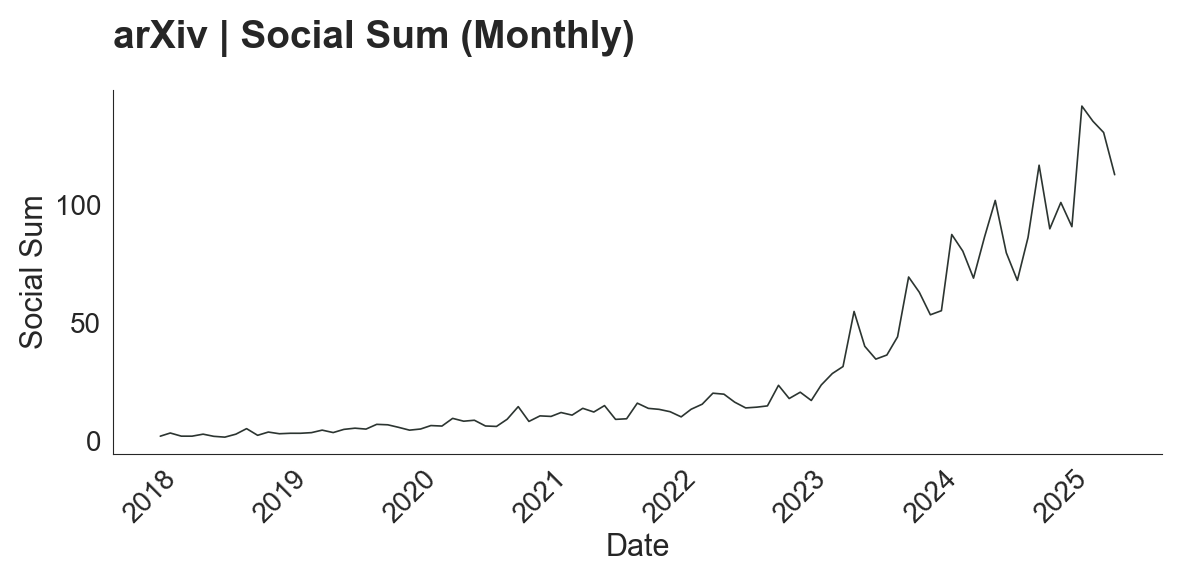

Plotting arxiv - social_sum (yearly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


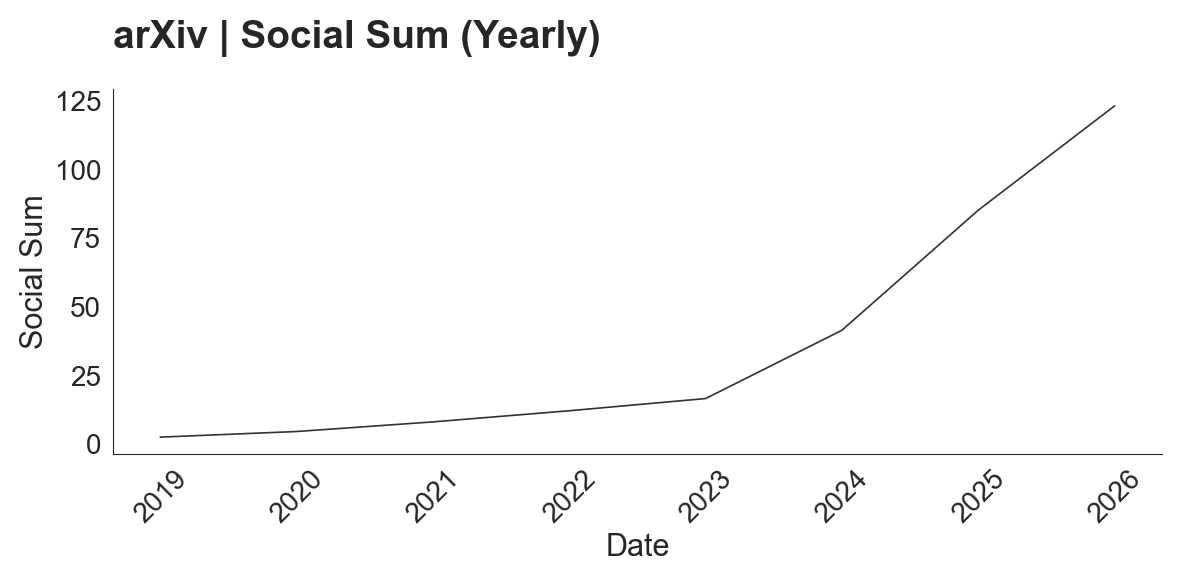

Plotting arxiv - ai_compound_sum (monthly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


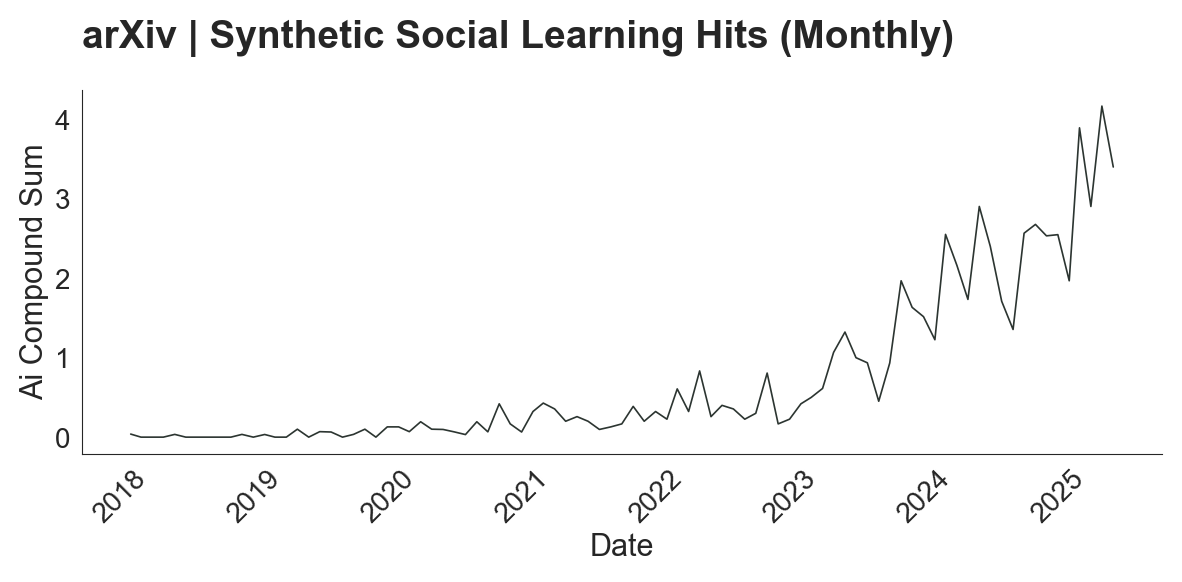

Plotting arxiv - ai_compound_sum (yearly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


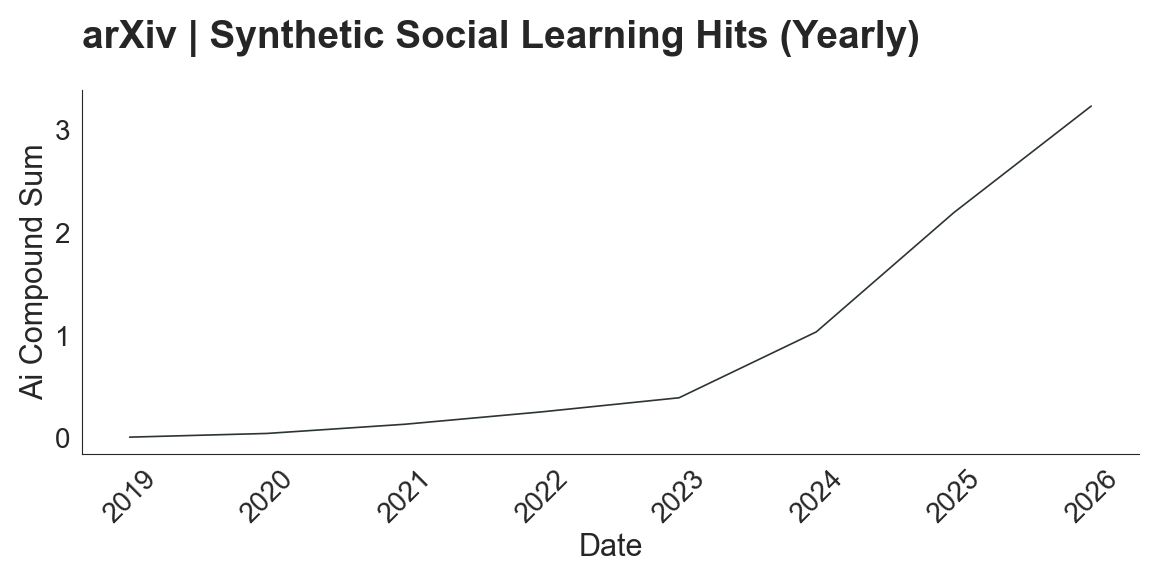

Plotting arxiv - social_binary (monthly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


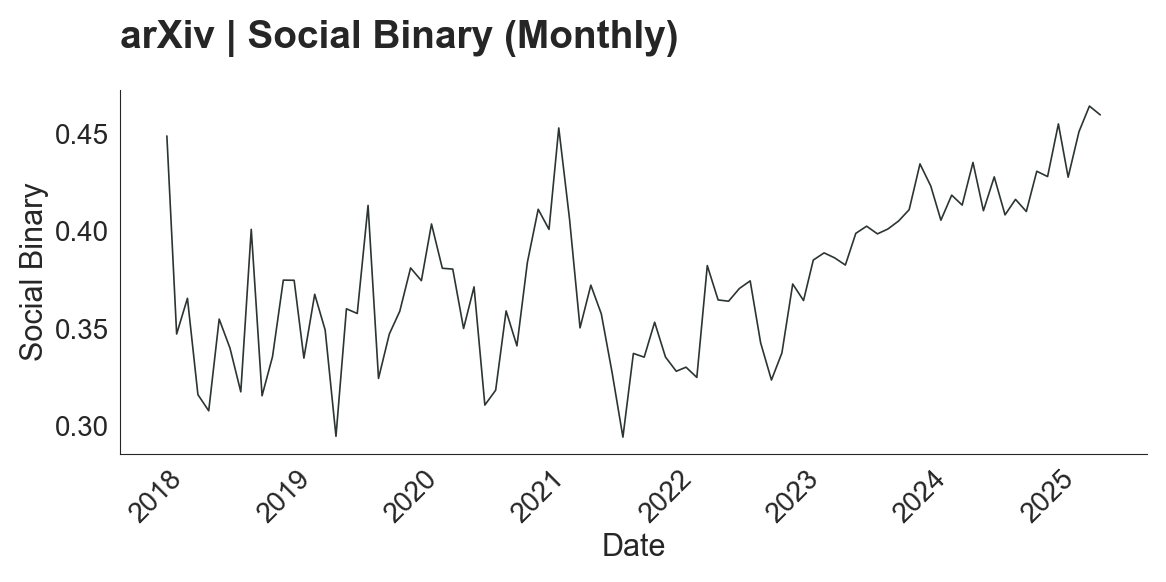

Plotting arxiv - social_binary (yearly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


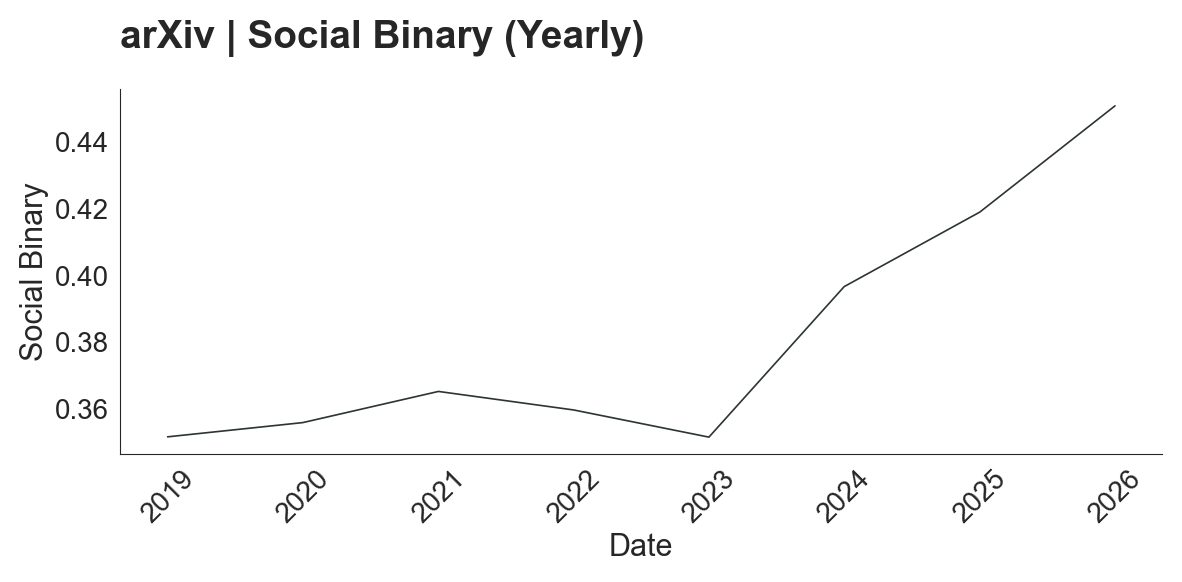

Plotting producthunt - social_sum (monthly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


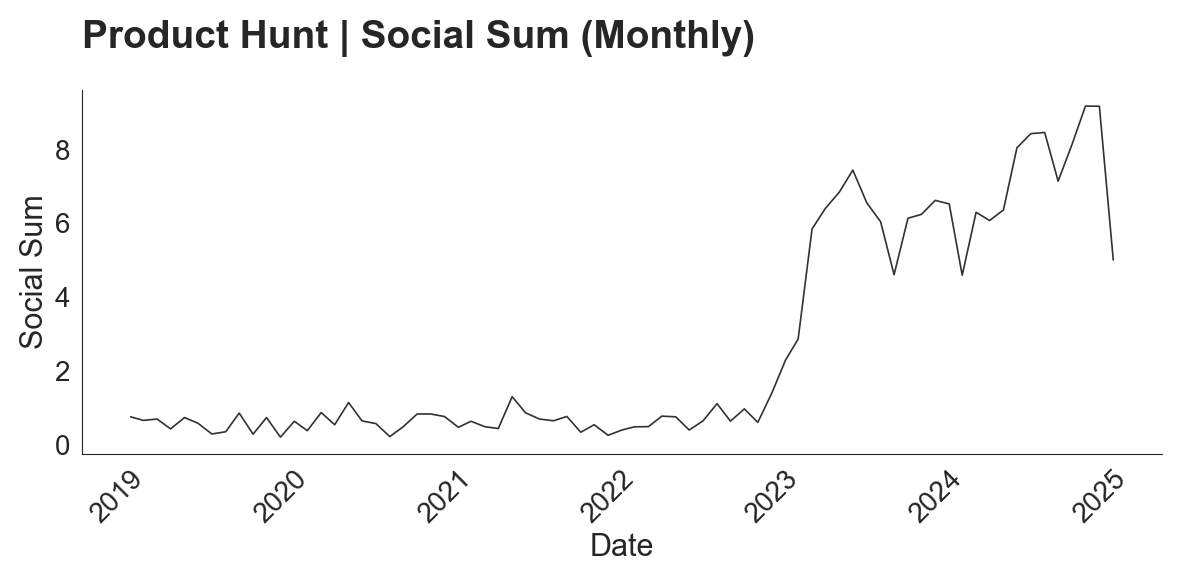

Plotting producthunt - social_sum (yearly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


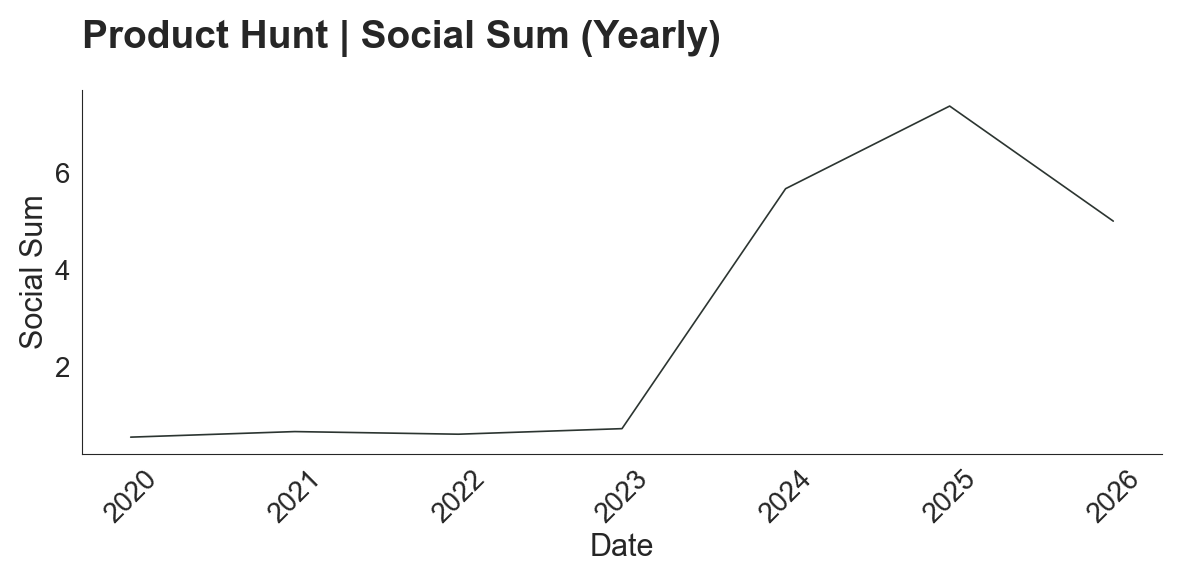

Plotting producthunt - ai_compound_sum (monthly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


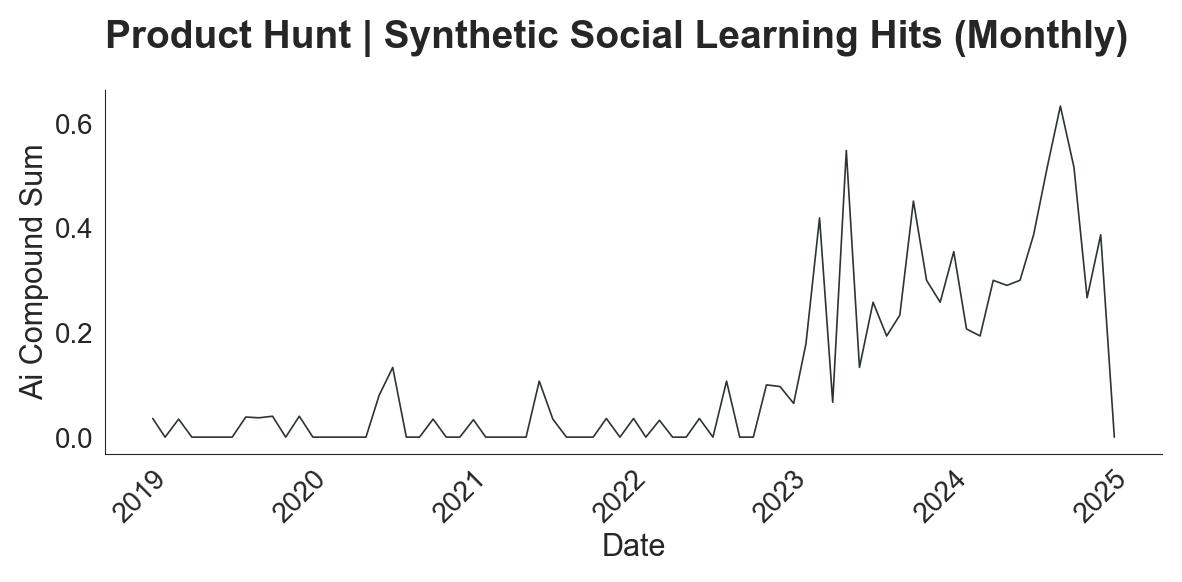

Plotting producthunt - ai_compound_sum (yearly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


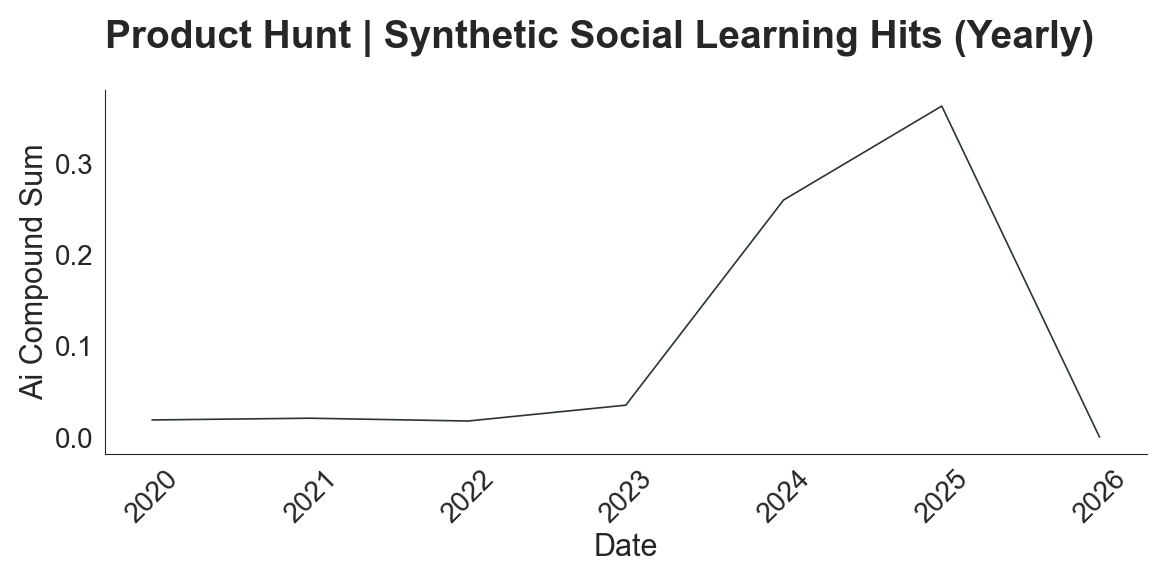

Plotting producthunt - social_binary (monthly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


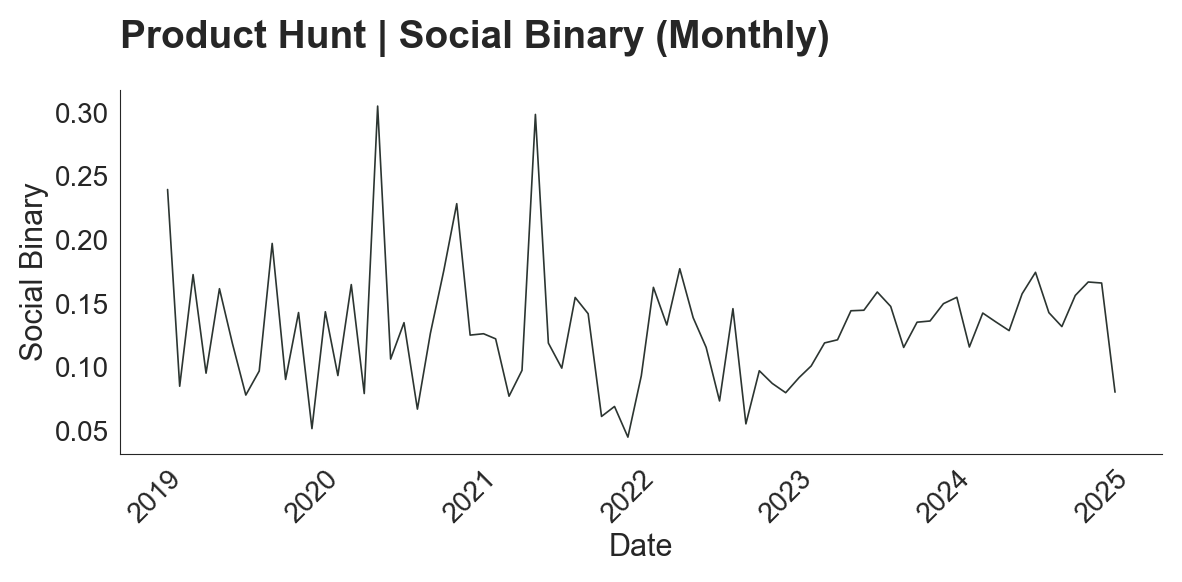

Plotting producthunt - social_binary (yearly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


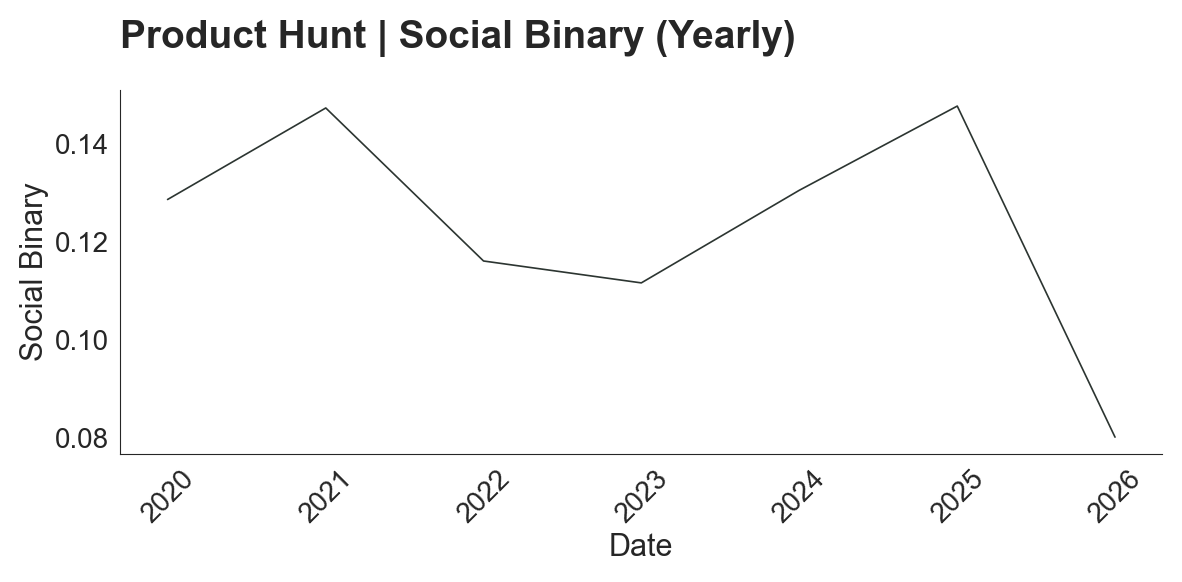

Plotting nyt - social_sum (monthly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


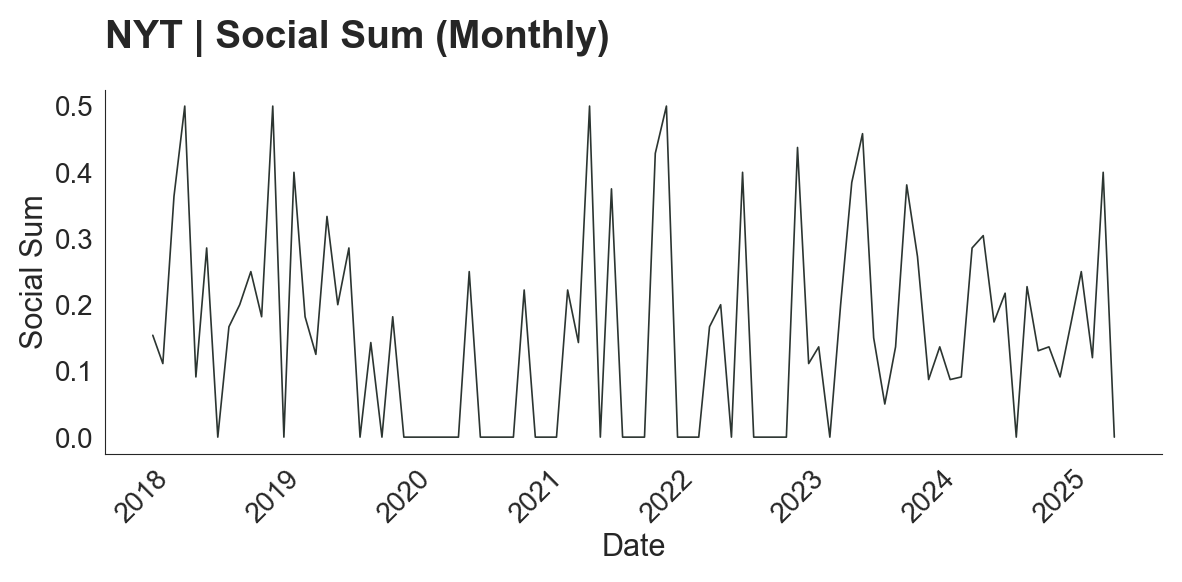

Plotting nyt - social_sum (yearly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


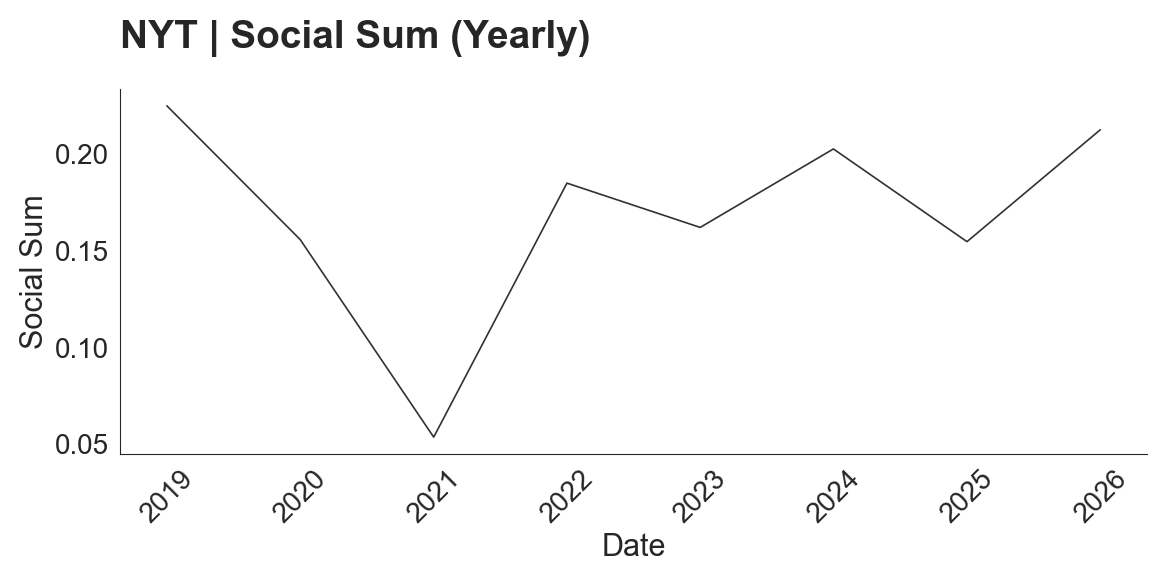

Plotting nyt - ai_compound_sum (monthly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


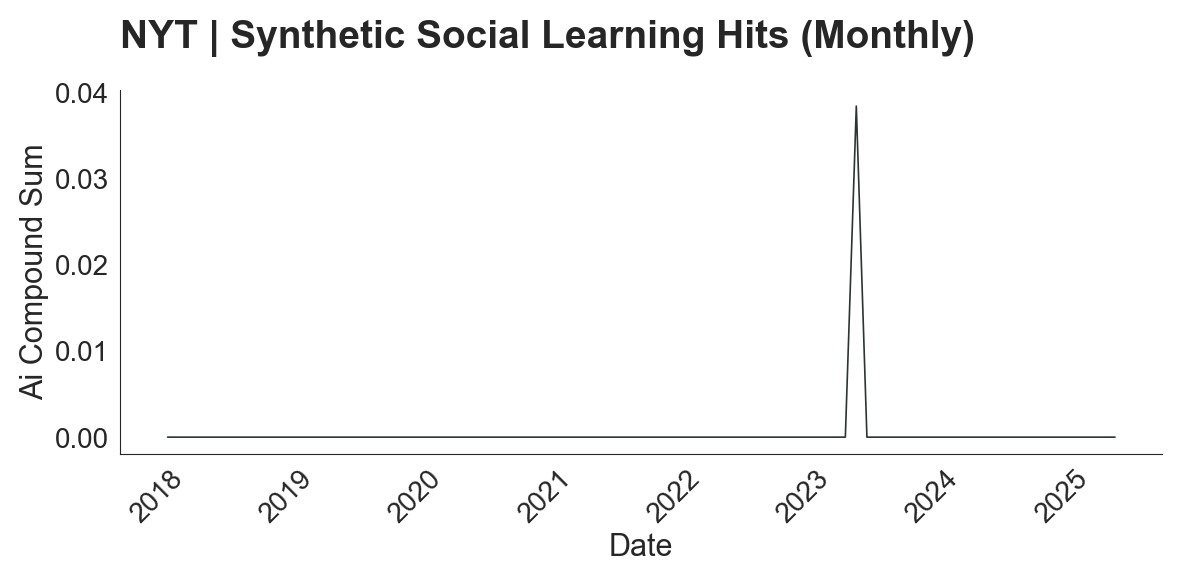

Plotting nyt - ai_compound_sum (yearly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


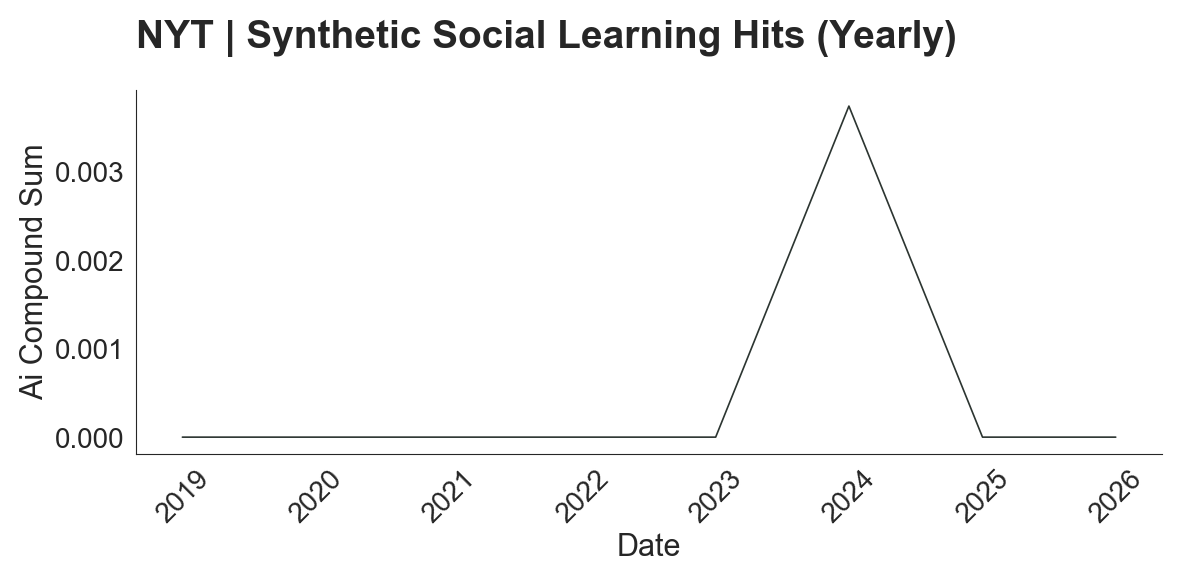

Plotting nyt - social_binary (monthly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


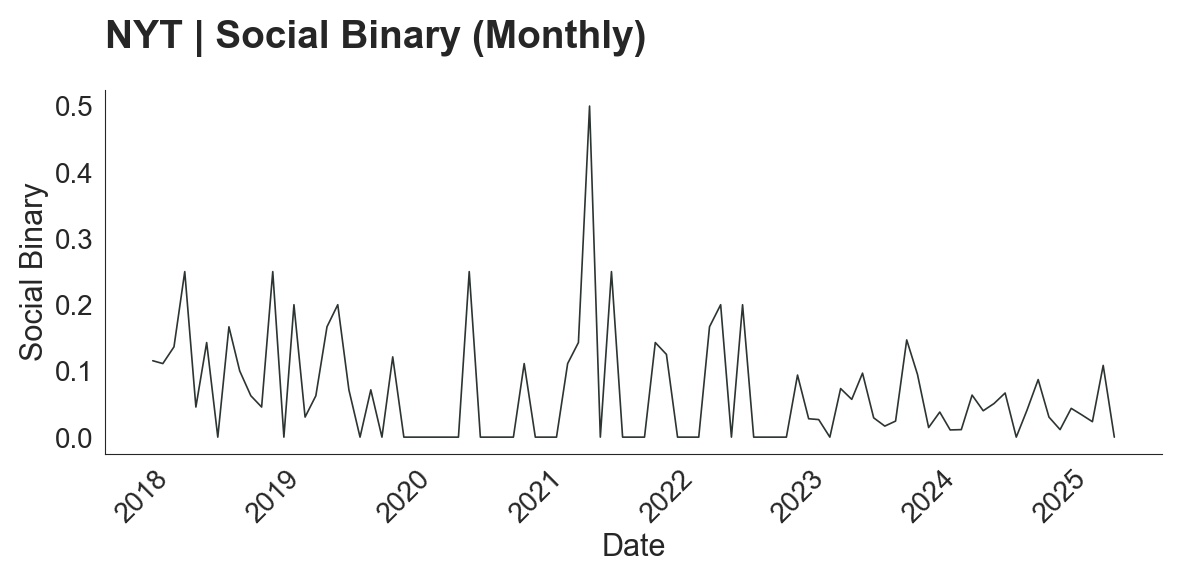

Plotting nyt - social_binary (yearly)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\4218223759.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


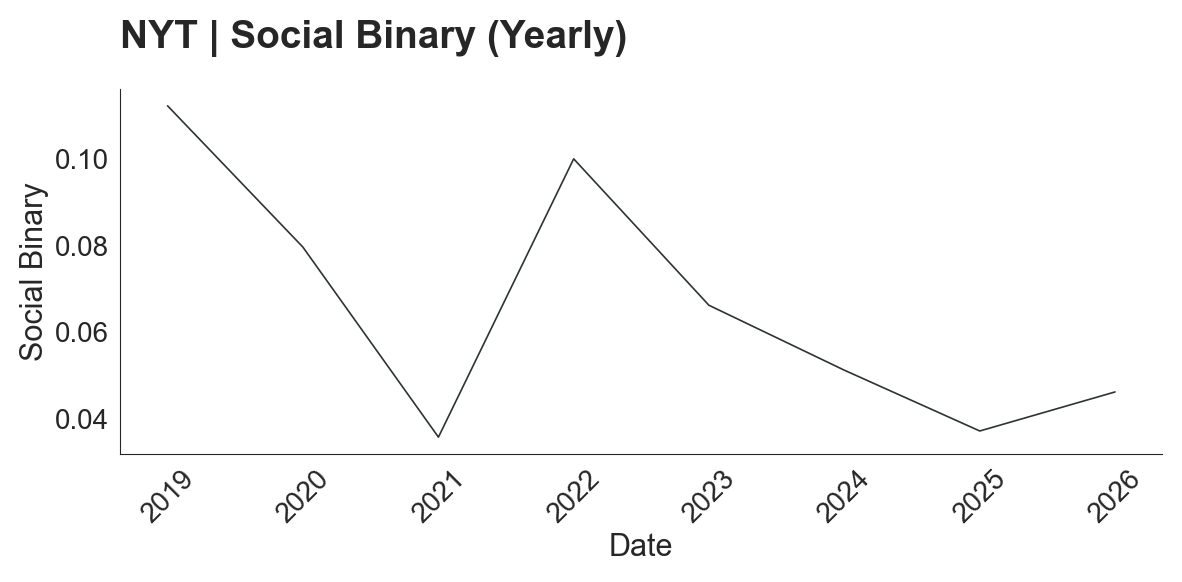

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd

def plot_ts(name, col, smoothing=False, period='daily', figsize=(12, 6)):
   """
   Plot time series for a given dataset and column.
   
   Parameters:
   -----------
   name : str
       Dataset name (key in byday dictionary)
   col : str
       Column name to plot
   smoothing : bool or int
       If True, applies 7-day rolling average. If int, uses that window size.
   period : str
       Aggregation period: 'daily', 'weekly', 'monthly', 'yearly'
   figsize : tuple
       Figure size (width, height)
   """
   
   clean_col = col.replace('_', ' ').title()
   if col == 'ai_compound_sum':
       clean_col = "Synthetic Social Learning Hits"
       
   
   source_dict = {
         'arxiv': 'arXiv',
         'nyt': 'NYT',
         'producthunt': 'Product Hunt'
   }
   clean_source = source_dict.get(name)
   if clean_col.startswith("Ai"):
         clean_col = clean_col.replace("Ai", "AI")
   
   if name not in byday:
       raise ValueError(f"Dataset '{name}' not found. Available: {list(byday.keys())}")
   
   df = byday[name].copy()
   
   if col not in df.columns:
       raise ValueError(f"Column '{col}' not found. Available: {df.columns.tolist()}")
   
   # Resample based on period
   if period == 'daily':
       df_plot = df.set_index('dt').resample('D')[col].sum().reset_index()
   elif period == 'weekly':
       df_plot = df.set_index('dt').resample('W')[col].mean().reset_index()
   elif period == 'monthly':
       df_plot = df.set_index('dt').resample('M')[col].mean().reset_index()
   elif period == 'yearly':
       df_plot = df.set_index('dt').resample('Y')[col].mean().reset_index()
   else:
       raise ValueError("Period must be 'daily', 'weekly', 'monthly', or 'yearly'")
   
   # Apply smoothing if requested
   if smoothing:
       window = 7 if smoothing is True else int(smoothing)
       df_plot[f'{col}_smooth'] = df_plot[col].rolling(window=window, center=True).mean()
       plot_col = f'{col}_smooth'
       line_label = f'{col} ({window}-period moving average)'
   else:
       plot_col = col
       line_label = col
   
   # Create plot
   plt.figure(figsize=figsize)
   plt.plot(df_plot['dt'], df_plot[plot_col])
   
   # Formatting
   plt.title(f'{clean_source} | {clean_col} ({period.title()})',  fontweight='bold')
   plt.xlabel('Date')
   plt.ylabel(col.replace('_', ' ').title())
   
   plt.xticks(rotation=45)
   plt.tight_layout()
   

   
   return df_plot

# Example usage:
for source in ['arxiv', 'producthunt', 'nyt']:
    for dv in ['social_sum', 'ai_compound_sum', 'social_binary']:
            for period in ['monthly', 'yearly']:
                print(f"Plotting {source} - {dv} ({period})")
                plot_ts(source, dv, smoothing=False, period=period)
                plt.show()




it has # grid plot

In [5]:
sorted(byday['arxiv'].columns)

['ai_binary',
 'ai_binary_sum',
 'ai_compound_binary',
 'ai_compound_binary_sum',
 'ai_compound_nouns_binary',
 'ai_compound_nouns_binary_sum',
 'ai_compound_nouns_sum',
 'ai_compound_nouns_sum_mean',
 'ai_compound_roles_binary',
 'ai_compound_roles_binary_sum',
 'ai_compound_roles_sum',
 'ai_compound_roles_sum_mean',
 'ai_compound_sum',
 'ai_compound_sum_mean',
 'ai_sum',
 'ai_sum_mean',
 'base-ai_binary',
 'base-ai_binary_sum',
 'base-ai_sum',
 'base-ai_sum_mean',
 'dt',
 'social_binary',
 'social_binary_sum',
 'social_sum',
 'social_sum_mean',
 'sum_social_word_counts_tfidf',
 'sum_social_word_counts_tfidf_mean',
 'total_count']

# Grid plot of all time series

In [6]:
sorted(dfs['arxiv'].columns)

['ai_binary',
 'ai_binary_sum',
 'ai_compound_binary',
 'ai_compound_binary_sum',
 'ai_compound_nouns_binary',
 'ai_compound_nouns_binary_sum',
 'ai_compound_nouns_sum',
 'ai_compound_nouns_sum_mean',
 'ai_compound_nouns_sum_mean_prop_wc',
 'ai_compound_nouns_word_counts',
 'ai_compound_roles_binary',
 'ai_compound_roles_binary_sum',
 'ai_compound_roles_sum',
 'ai_compound_roles_sum_mean',
 'ai_compound_roles_sum_mean_prop_wc',
 'ai_compound_roles_word_counts',
 'ai_compound_sum',
 'ai_compound_sum_mean',
 'ai_compound_sum_mean_prop_wc',
 'ai_compound_word_counts',
 'ai_sum',
 'ai_sum_mean',
 'ai_sum_mean_prop_wc',
 'ai_word_counts',
 'analysis_date',
 'base-ai_binary',
 'base-ai_binary_sum',
 'base-ai_sum',
 'base-ai_sum_mean',
 'base-ai_sum_mean_prop_wc',
 'base-ai_word_counts',
 'dt',
 'social_binary',
 'social_binary_sum',
 'social_sum',
 'social_sum_mean',
 'social_sum_mean_prop_wc',
 'social_word_counts',
 'social_word_counts_tfidf',
 'sum_social_word_counts_tfidf',
 'sum_social_

C:\Users\Alexi\AppData\Local\Temp\ipykernel_21676\1852753636.py:166: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=2.0, w_pad=1.0)


✅  Saved grid to all_time_series.png


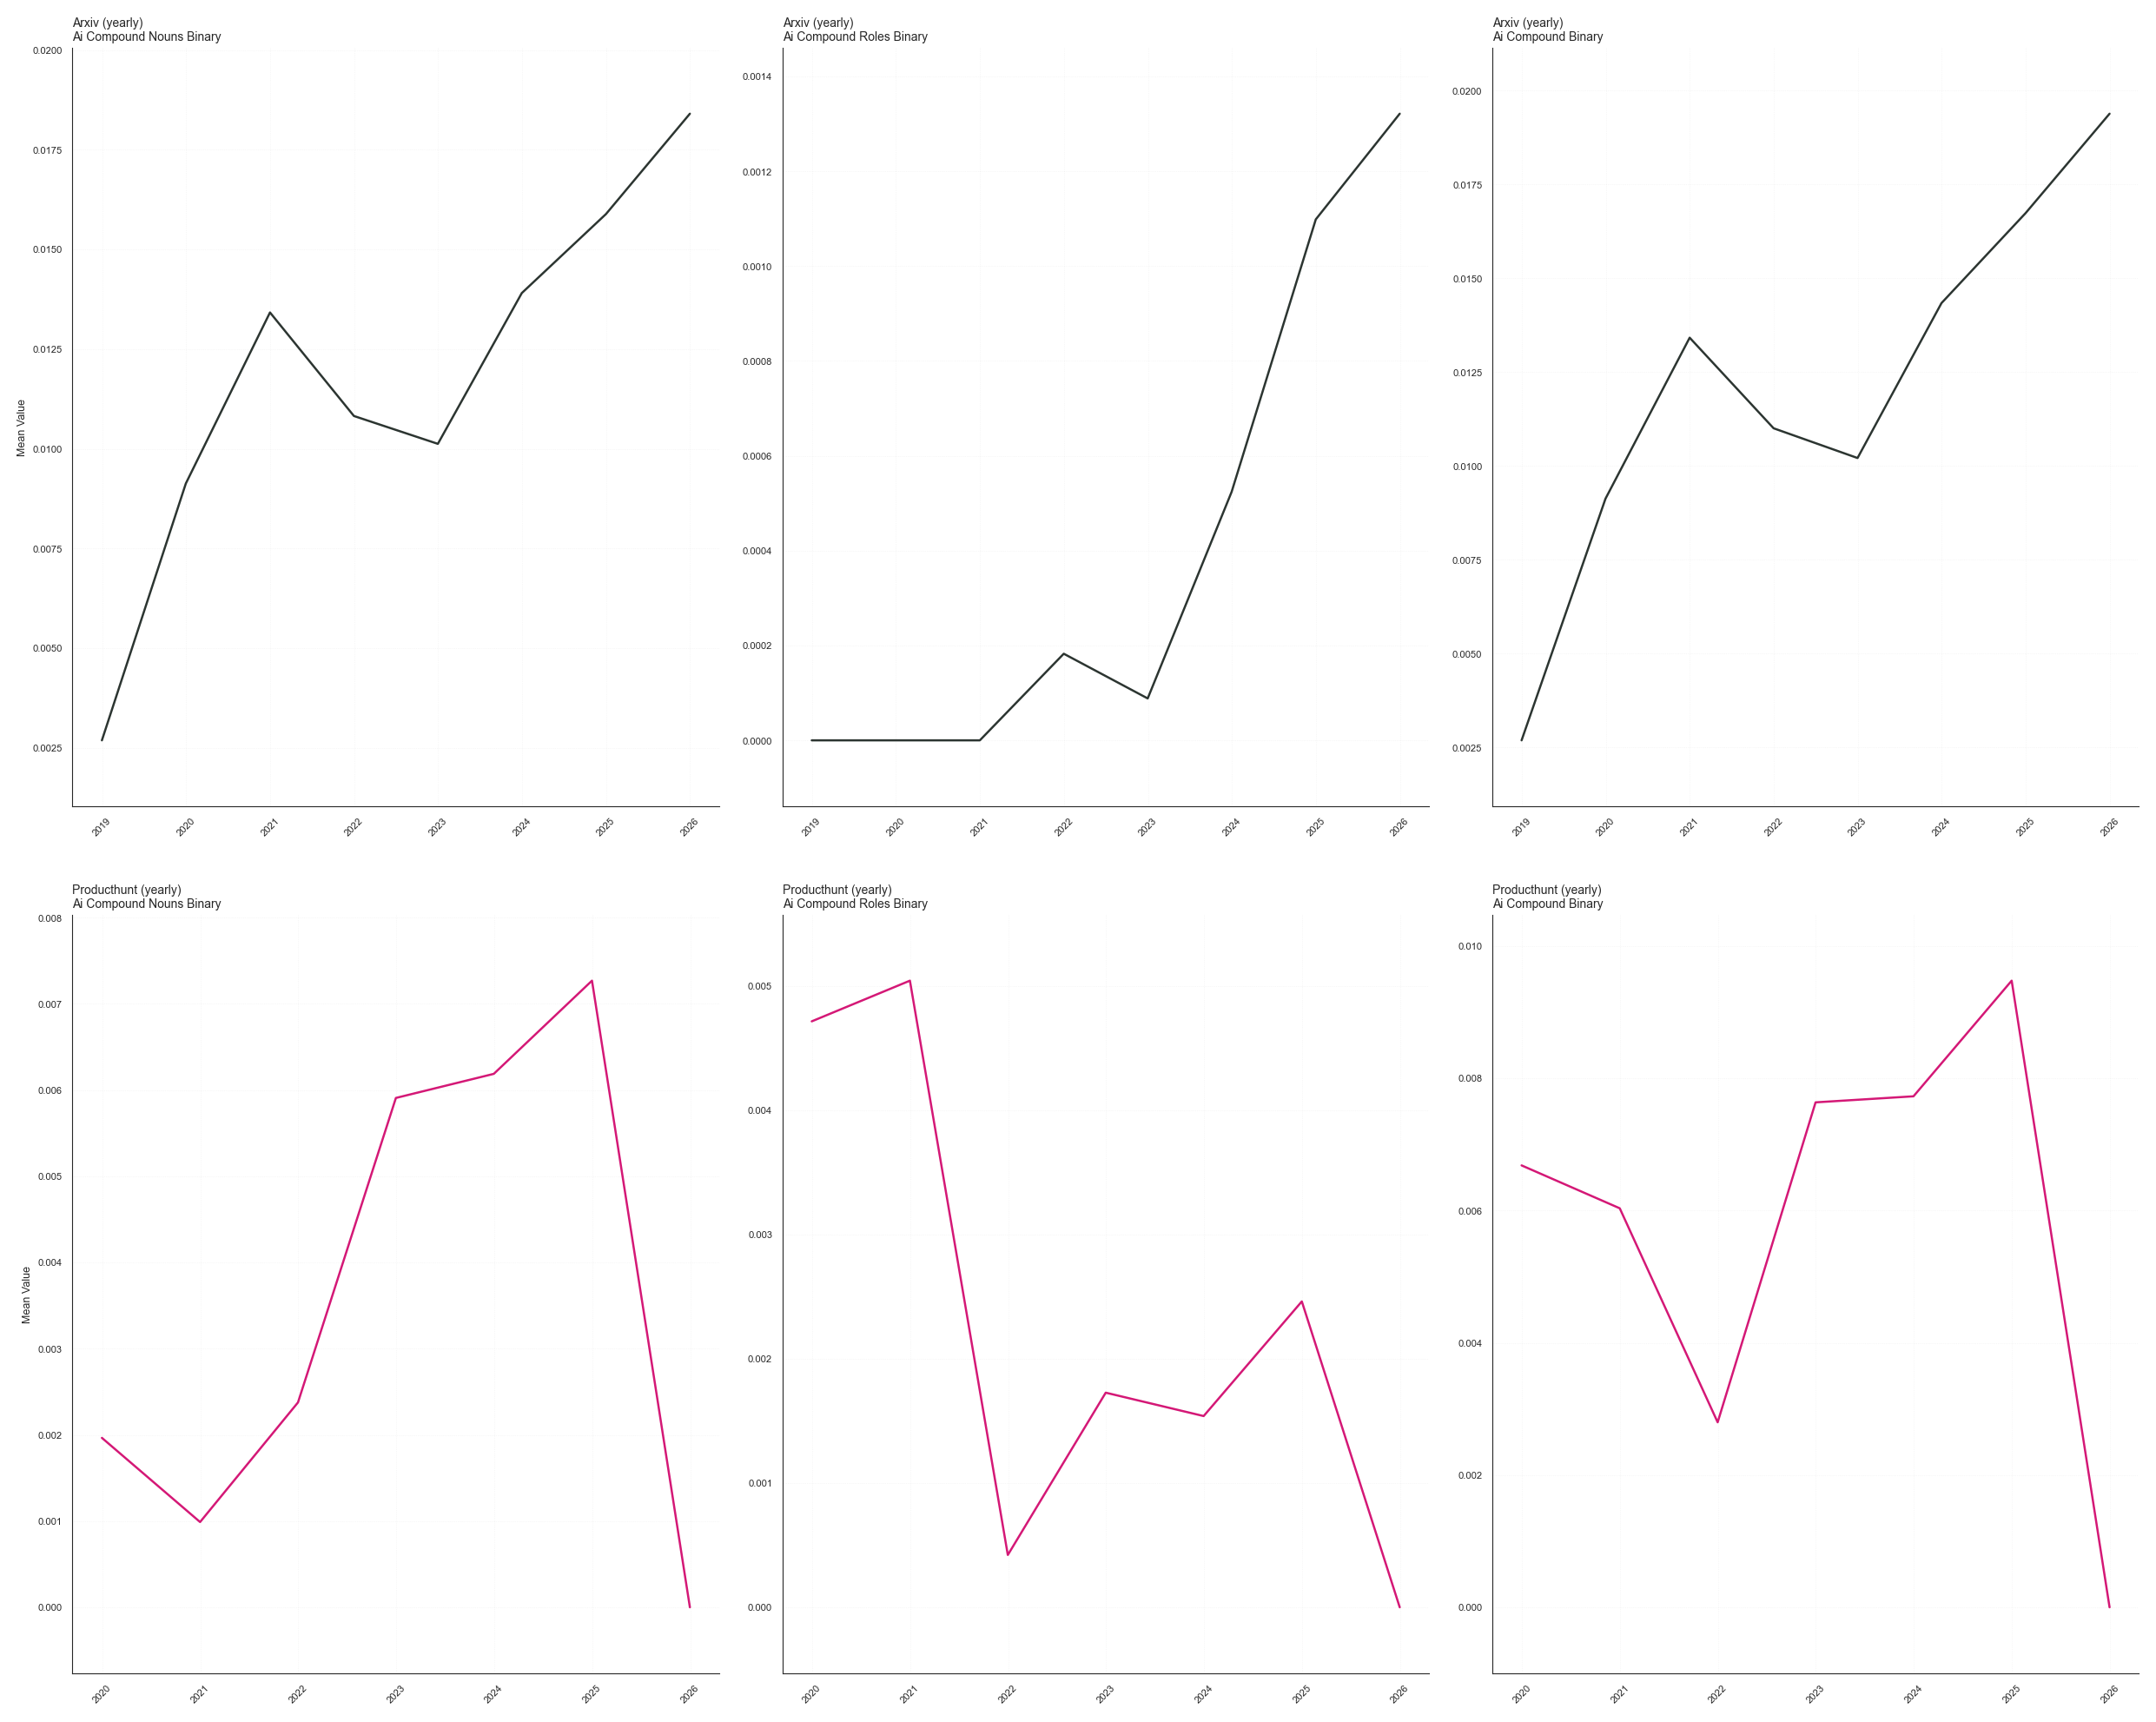

In [7]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os


def save_all_ts_grid(
    byday_dict,                      # Pass byday as parameter
    sources=('arxiv', 'producthunt'),
    dvs=('ai_compound_nouns_binary', 'ai_compound_roles_binary', 'ai_compound_binary'),
    periods=('yearly',),
    smoothing=False,                 # or e.g. 7 for a 7-day MA
    figsize=(25, 20),                # tweak as needed
    dpi=300,                         # high-resolution
    out_fn='all_time_series.png'
):
    """
    Saves a grid of time-series plots (source × period × DV) to `out_fn`.
    
    Args:
        byday_dict: Dictionary containing DataFrames for each source
        sources: Tuple of source names to plot
        dvs: Tuple of dependent variables (column names) to plot
        periods: Tuple of time periods for aggregation
        smoothing: False, True (7-day default), or integer for window size
        figsize: Figure size tuple
        dpi: Resolution for saved figure
        out_fn: Output filename
    """
    
    # Validate inputs
    for source in sources:
        if source not in byday_dict:
            raise ValueError(f"Source '{source}' not found in byday_dict")
    
    mypal = make_aesthetic()
    
    n_rows = len(sources) * len(periods)   
    n_cols = len(dvs)                      
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=False, sharey=False)
    
    # Handle single subplot case
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    color_map = {
        'arxiv': mypal[0],
        'producthunt': mypal[1], 
        'nyt': mypal[2],
    }
    
    # Add more colors if needed
    for i, source in enumerate(sources):
        if source not in color_map:
            color_map[source] = mypal[i % len(mypal)]

    axes_iter = axes.reshape(-1, n_cols)

    for r, (source, period) in enumerate(
        [(s, p) for s in sources for p in periods]   # keeps the grid order stable
    ):
        for c, dv in enumerate(dvs):
            ax = axes_iter[r, c]

            try:
                df = byday_dict[source].copy()
                
                # Check if column exists
                if dv not in df.columns:
                    ax.text(0.5, 0.5, f'Column {dv}\nnot found', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{source} ({period})\n{dv}', pad=6)
                    continue
                
                # Ensure dt is datetime
                if not pd.api.types.is_datetime64_any_dtype(df['dt']):
                    df['dt'] = pd.to_datetime(df['dt'])
                
                # Determine aggregation method based on column name
                if 'sum' in dv.lower() and 'mean' not in dv.lower():
                    agg_method = 'sum'
                elif 'binary' in dv.lower() and 'sum' not in dv.lower():
                    agg_method = 'mean'  # For proportions
                elif 'mean' in dv.lower():
                    agg_method = 'mean'
                elif 'count' in dv.lower():
                    agg_method = 'sum'
                else:
                    agg_method = 'mean'  # Default fallback

                # Aggregate to the requested period
                df_indexed = df.set_index('dt')
                
                if period == 'daily':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('D')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('D')[dv].mean().reset_index()
                elif period == 'weekly':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('W')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('W')[dv].mean().reset_index()
                elif period == 'monthly':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('M')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('M')[dv].mean().reset_index()
                elif period == 'yearly':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('Y')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('Y')[dv].mean().reset_index()
                else:
                    raise ValueError("period must be 'daily', 'weekly', 'monthly', or 'yearly'")

                # Remove any NaN values
                df_plot = df_plot.dropna()
                
                if len(df_plot) == 0:
                    ax.text(0.5, 0.5, 'No data\navailable', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{source} ({period})\n{dv}', pad=6)
                    continue

                # Optional smoothing
                plot_col = dv
                if smoothing and len(df_plot) > 2:
                    window = 7 if smoothing is True else int(smoothing)
                    window = min(window, len(df_plot))  # Don't exceed data length
                    df_plot[f'{dv}_smooth'] = df_plot[dv].rolling(window, center=True, min_periods=1).mean()
                    plot_col = f'{dv}_smooth'

                # Draw the line
                ax.plot(df_plot['dt'], df_plot[plot_col], 
                       linewidth=1.8, color=color_map.get(source, mypal[0]))
                
                # Format title and labels
                clean_dv = dv.replace('_', ' ').title()
                ax.set_title(f'{source.title()} ({period})\n{clean_dv}', pad=6, fontsize=10)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
                ax.tick_params(axis='y', labelsize=8)
                ax.grid(alpha=0.3)

                # Add some padding to y-axis
                y_min, y_max = ax.get_ylim()
                y_range = y_max - y_min
                ax.set_ylim(y_min - 0.05 * y_range, y_max + 0.05 * y_range)

                # Light y-label only on leftmost column
                if c == 0:
                    ax.set_ylabel(f'{agg_method.title()} Value', fontsize=9)
                    
            except Exception as e:
                # Handle errors gracefully
                ax.text(0.5, 0.5, f'Error:\n{str(e)[:50]}...', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=8)
                ax.set_title(f'{source} ({period})\n{dv}', pad=6)
                print(f"Warning: Error plotting {source}-{period}-{dv}: {e}")

    fig.tight_layout(h_pad=2.0, w_pad=1.0)
    
    # Save before showing to avoid issues
    fig.savefig(out_fn, dpi=dpi, bbox_inches='tight')
    print(f"✅  Saved grid to {out_fn}")
    
    plt.show()
    plt.close(fig)

save_all_ts_grid(byday)

In [16]:
dfs['arxiv'].columns

Index(['base-ai_word_counts', 'ai_word_counts', 'social_word_counts',
       'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts',
       'ai_compound_word_counts', 'base-ai_sum', 'ai_sum', 'social_sum',
       'ai_compound_roles_sum', 'ai_compound_nouns_sum', 'ai_compound_sum',
       'base-ai_binary', 'ai_binary', 'social_binary',
       'ai_compound_roles_binary', 'ai_compound_nouns_binary',
       'ai_compound_binary', 'analysis_date', 'unique_idx', 'text', 'wc', 'dt',
       'total_count', 'social_word_counts_tfidf',
       'sum_social_word_counts_tfidf', 'base-ai_sum_mean',
       'base-ai_sum_mean_prop_wc', 'ai_sum_mean', 'ai_sum_mean_prop_wc',
       'social_sum_mean', 'social_sum_mean_prop_wc',
       'ai_compound_roles_sum_mean', 'ai_compound_roles_sum_mean_prop_wc',
       'ai_compound_nouns_sum_mean', 'ai_compound_nouns_sum_mean_prop_wc',
       'ai_compound_sum_mean', 'ai_compound_sum_mean_prop_wc',
       'sum_social_word_counts_tfidf_mean',
       'sum_social

# Top Things


In [12]:
def view_top_bottom(df, col, n):
    """
    View top and bottom values of a specific column in a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze
        col (str): The column name to view
    
    Returns:
        pd.DataFrame: DataFrame with top and bottom values of the specified column
    """
    top = df.nlargest(n, col)
    bottom = df.nsmallest(n, col)
    
    print("TOP")
    for index, row in top.iterrows():
        text = row['text']
        print(f"{row[col]:.2f} - {text[:40*1000]}...") 
        print("---"*10)
        
    print("BOTTOM")
    for index, row in bottom.iterrows():
        text = row['text']
        print(f"{row[col]:.2f} - {text[:40*1000]}...") 
        print("---"*10)
    
    return pd.concat([top, bottom]).reset_index(drop=True)


view_top_bottom(dfs['arxiv'], 'sum_social_word_counts_tfidf_mean_prop_wc', 30)

TOP
22.73 - ai code generators for security: friend or foe? recent advances of artificial intelligence (ai) code generators are opening new opportunities in software security research, including misuse by malicious actors. we review use cases for ai code generators for security and introduce an evaluation benchmark....
------------------------------
11.36 - sabi\'a-3 technical report this report presents sabi\'a-3, our new flagship language model, and sabiazinho-3, a more cost-effective sibling. the models were trained on a large brazilian-centric corpus. evaluations across diverse professional and academic benchmarks show a strong performance on portuguese and brazil-related tasks. sabi\'a-3 shows large improvements in comparison to our previous best of model, sabia-2 medium, especially in reasoning-intensive tasks. notably, sabi\'a-3's average performance matches frontier llms, while it is offered at a three to four times lower cost per token, reinforcing the benefits of domain speci

,base-ai_word_counts,ai_word_counts,social_word_counts,ai_compound_roles_word_counts,ai_compound_nouns_word_counts,ai_compound_word_counts,base-ai_sum,ai_sum,social_sum,ai_compound_roles_sum,...,ai_compound_sum_mean,ai_compound_sum_mean_prop_wc,sum_social_word_counts_tfidf_mean,sum_social_word_counts_tfidf_mean_prop_wc,base-ai_binary_sum,ai_binary_sum,social_binary_sum,ai_compound_roles_binary_sum,ai_compound_nouns_binary_sum,ai_compound_binary_sum
0,"{'ai': 3, 'artificial intelligence': 1}","{'ai': 3, 'artificial intelligence': 1}",{'friend': 1},{},{},{},4,4,1,0,...,0,0.0,1000,22.727273,1,1,1,0,0,0
1,{},"{'language model': 1, 'llms': 1}",{'sibling': 1},{},{},{},0,2,1,0,...,0,0.0,1000,11.363636,0,1,1,0,0,0
2,{},{'language models': 1},{'therapist': 2},{},{},{},0,1,2,0,...,0,0.0,1000,10.638298,0,1,1,0,0,0
3,{},{'transformers': 1},{'parent': 1},{},{},{},0,1,1,0,...,0,0.0,1000,10.204082,0,1,1,0,0,0
4,{},{'chatbots': 3},{'advisor': 1},{},{},{},0,3,1,0,...,0,0.0,1000,10.101010,0,1,1,0,0,0
5,{},{'language models': 3},{'employee': 2},{},{},{},0,3,2,0,...,0,0.0,1000,10.000000,0,1,1,0,0,0
6,{},{'language models': 1},{'parent': 1},{},{},{},0,1,1,0,...,0,0.0,1000,9.345794,0,1,1,0,0,0
7,{'ai': 4},{'ai': 4},{'advisor': 1},{},{},{},4,4,1,0,...,0,0.0,1000,8.620690,1,1,1,0,0,0
8,{'ai': 1},"{'ai': 1, 'llms': 1}",{'friend': 1},{},{},{},1,2,1,0,...,0,0.0,1000,7.936508,1,1,1,0,0,0
9,{'artificial intelligence': 1},{'artificial intelligence': 1},{'encouragement': 1},{},{},{},1,1,1,0,...,0,0.0,1000,7.812500,1,1,1,0,0,0


In [13]:
bad_words = ['communication', "dialogue"]

## SSL Outcome Variable Exploration

Candidate columns are explored to identify the one that best reflects machine-generated social knowledge. Variables were selected based on relevance to social, AI, or compound role-based content.


### Recommended variable


In [17]:
view_top_bottom(dfs['arxiv'], 'sum_social_word_counts_tfidf_mean_prop_wc', 50)


TOP
22.73 - ai code generators for security: friend or foe? recent advances of artificial intelligence (ai) code generators are opening new opportunities in software security research, including misuse by malicious actors. we review use cases for ai code generators for security and introduce an evaluation benchmark....
------------------------------
11.36 - sabi\'a-3 technical report this report presents sabi\'a-3, our new flagship language model, and sabiazinho-3, a more cost-effective sibling. the models were trained on a large brazilian-centric corpus. evaluations across diverse professional and academic benchmarks show a strong performance on portuguese and brazil-related tasks. sabi\'a-3 shows large improvements in comparison to our previous best of model, sabia-2 medium, especially in reasoning-intensive tasks. notably, sabi\'a-3's average performance matches frontier llms, while it is offered at a three to four times lower cost per token, reinforcing the benefits of domain speci

,base-ai_word_counts,ai_word_counts,social_word_counts,ai_compound_roles_word_counts,ai_compound_nouns_word_counts,ai_compound_word_counts,base-ai_sum,ai_sum,social_sum,ai_compound_roles_sum,...,ai_compound_sum_mean,ai_compound_sum_mean_prop_wc,sum_social_word_counts_tfidf_mean,sum_social_word_counts_tfidf_mean_prop_wc,base-ai_binary_sum,ai_binary_sum,social_binary_sum,ai_compound_roles_binary_sum,ai_compound_nouns_binary_sum,ai_compound_binary_sum
0,"{'ai': 3, 'artificial intelligence': 1}","{'ai': 3, 'artificial intelligence': 1}",{'friend': 1},{},{},{},4,4,1,0,...,0,0.0,1000,22.727273,1,1,1,0,0,0
1,{},"{'language model': 1, 'llms': 1}",{'sibling': 1},{},{},{},0,2,1,0,...,0,0.0,1000,11.363636,0,1,1,0,0,0
2,{},{'language models': 1},{'therapist': 2},{},{},{},0,1,2,0,...,0,0.0,1000,10.638298,0,1,1,0,0,0
3,{},{'transformers': 1},{'parent': 1},{},{},{},0,1,1,0,...,0,0.0,1000,10.204082,0,1,1,0,0,0
4,{},{'chatbots': 3},{'advisor': 1},{},{},{},0,3,1,0,...,0,0.0,1000,10.101010,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{'artificial intelligence': 1},{'artificial intelligence': 1},{},{},{},{},1,1,0,0,...,0,0.0,0,0.000000,1,1,0,0,0,0
96,"{'artificial intelligence': 1, 'ai': 3}","{'artificial intelligence': 1, 'ai': 3}",{},{},{},{},4,4,0,0,...,0,0.0,0,0.000000,1,1,0,0,0,0
97,"{'artificial intelligence': 1, 'ai': 2}","{'artificial intelligence': 1, 'ai': 2}",{},{},{},{},3,3,0,0,...,0,0.0,0,0.000000,1,1,0,0,0,0
98,{'artificial intelligence': 4},{'artificial intelligence': 4},{},{},{},{},4,4,0,0,...,0,0.0,0,0.000000,1,1,0,0,0,0


### Compound role-based candidates


In [18]:
view_top_bottom(dfs['arxiv'], 'ai_compound_roles_sum_mean_prop_wc', 50)


TOP
0.03 - the corruptive force of ai-generated advice artificial intelligence (ai) is increasingly becoming a trusted advisor in people's lives. a new concern arises if ai persuades people to break ethical rules for profit. employing a large-scale behavioural experiment (n = 1,572), we test whether ai-generated advice can corrupt people. we further test whether transparency about ai presence, a commonly proposed policy, mitigates potential harm of ai-generated advice. using the natural language processing algorithm, gpt-2, we generated honesty-promoting and dishonesty-promoting advice. participants read one type of advice before engaging in a task in which they could lie for profit. testing human behaviour in interaction with actual ai outputs, we provide first behavioural insights into the role of ai as an advisor. results reveal that ai-generated advice corrupts people, even when they know the source of the advice. in fact, ai's corrupting force is as strong as humans'....
---------

,base-ai_word_counts,ai_word_counts,social_word_counts,ai_compound_roles_word_counts,ai_compound_nouns_word_counts,ai_compound_word_counts,base-ai_sum,ai_sum,social_sum,ai_compound_roles_sum,...,ai_compound_sum_mean,ai_compound_sum_mean_prop_wc,sum_social_word_counts_tfidf_mean,sum_social_word_counts_tfidf_mean_prop_wc,base-ai_binary_sum,ai_binary_sum,social_binary_sum,ai_compound_roles_binary_sum,ai_compound_nouns_binary_sum,ai_compound_binary_sum
0,"{'ai': 10, 'artificial intelligence': 1}","{'ai': 10, 'artificial intelligence': 1, 'gpt-...","{'advice': 7, 'advisor': 2, 'interaction': 1}",{'ai-generated advice': 4},{},{'ai-generated advice': 4},11,12,10,4,...,4,0.027586,416,2.868966,1,1,1,1,0,1
1,{},"{'llm': 4, 'large language model': 1}","{'feedback': 5, 'relationship': 3, 'understand...","{'llm-driven feedback': 1, 'llm-generated feed...",{},"{'llm-driven feedback': 1, 'llm-generated feed...",0,5,9,2,...,2,0.016529,33,0.272727,0,1,1,1,0,1
2,"{'ai': 5, 'artificial intelligence': 1}","{'ai': 5, 'artificial intelligence': 1}","{'feedback': 8, 'understanding': 1, 'interacti...","{'ai-generated feedback': 2, 'ai-driven feedba...",{},"{'ai-generated feedback': 2, 'ai-driven feedba...",6,6,10,3,...,3,0.014423,22,0.105769,1,1,1,1,0,1
3,{},{'llm': 4},{'feedback': 6},{'llm-generated feedback': 2},{'llm feedback': 1},"{'llm-generated feedback': 2, 'llm feedback': 1}",0,4,6,2,...,3,0.020979,24,0.167832,0,1,1,1,1,1
4,{'ai': 6},{'ai': 6},"{'trust': 1, 'advice': 2}",{'ai-generated advice': 2},{},{'ai-generated advice': 2},6,6,3,2,...,2,0.013793,221,1.524138,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{'artificial intelligence': 1},{'artificial intelligence': 1},{},{},{},{},1,1,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
96,"{'artificial intelligence': 1, 'ai': 1}","{'artificial intelligence': 1, 'ai': 1}",{},{},{},{},2,2,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
97,{'ai': 1},{'ai': 1},{},{},{},{},1,1,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
98,{},{'language models': 1},{},{},{},{},0,1,0,0,...,0,0.000000,0,0.000000,0,1,0,0,0,0


In [19]:
view_top_bottom(dfs['arxiv'], 'ai_compound_nouns_sum_mean_prop_wc', 50)


TOP
0.05 - player-ai interaction: what neural network games reveal about ai as play the advent of artificial intelligence (ai) and machine learning (ml) bring human-ai interaction to the forefront of hci research. this paper argues that games are an ideal domain for studying and experimenting with how humans interact with ai. through a systematic survey of neural network games (n = 38), we identified the dominant interaction metaphors and ai interaction patterns in these games. in addition, we applied existing human-ai interaction guidelines to further shed light on player-ai interaction in the context of ai-infused systems. our core finding is that ai as play can expand current notions of human-ai interaction, which are predominantly productivity-based. in particular, our work suggests that game and ux designers should consider flow to structure the learning curve of human-ai interaction, incorporate discovery-based learning to play around with the ai and observe the consequences, and

,base-ai_word_counts,ai_word_counts,social_word_counts,ai_compound_roles_word_counts,ai_compound_nouns_word_counts,ai_compound_word_counts,base-ai_sum,ai_sum,social_sum,ai_compound_roles_sum,...,ai_compound_sum_mean,ai_compound_sum_mean_prop_wc,sum_social_word_counts_tfidf_mean,sum_social_word_counts_tfidf_mean_prop_wc,base-ai_binary_sum,ai_binary_sum,social_binary_sum,ai_compound_roles_binary_sum,ai_compound_nouns_binary_sum,ai_compound_binary_sum
0,"{'ai': 14, 'artificial intelligence': 1}","{'ai': 14, 'artificial intelligence': 1}",{'interaction': 9},{},{'ai interaction': 8},{'ai interaction': 8},15,15,9,0,...,8,0.049689,21,0.130435,1,1,1,0,1,1
1,{'ai': 13},{'ai': 13},{'feedback': 13},{},{'ai feedback': 11},{'ai feedback': 11},13,13,13,0,...,11,0.048889,24,0.106667,1,1,1,0,1,1
2,{'ai': 5},"{'ai': 4, 'ai agents': 1}",{'collaboration': 2},{},{'ai collaboration': 2},{'ai collaboration': 2},5,5,2,0,...,2,0.035714,49,0.875000,1,1,1,0,1,1
3,{'ai': 13},{'ai': 13},"{'communication': 7, 'interaction': 1}",{},{'ai communication': 6},{'ai communication': 6},13,13,8,0,...,6,0.035294,27,0.158824,1,1,1,0,1,1
4,{'ai': 19},{'ai': 19},"{'collaboration': 6, 'trust': 4, 'advice': 1, ...",{},"{'ai collaboration': 5, 'ai advice': 1}","{'ai collaboration': 5, 'ai advice': 1}",19,19,14,0,...,6,0.032258,60,0.322581,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{'artificial intelligence': 1},{'artificial intelligence': 1},{},{},{},{},1,1,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
96,"{'artificial intelligence': 1, 'ai': 1}","{'artificial intelligence': 1, 'ai': 1}",{},{},{},{},2,2,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
97,{'ai': 1},{'ai': 1},{},{},{},{},1,1,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
98,{},{'language models': 1},{},{},{},{},0,1,0,0,...,0,0.000000,0,0.000000,0,1,0,0,0,0


In [20]:
view_top_bottom(dfs['arxiv'], 'ai_compound_sum_mean_prop_wc', 50)


TOP
0.05 - player-ai interaction: what neural network games reveal about ai as play the advent of artificial intelligence (ai) and machine learning (ml) bring human-ai interaction to the forefront of hci research. this paper argues that games are an ideal domain for studying and experimenting with how humans interact with ai. through a systematic survey of neural network games (n = 38), we identified the dominant interaction metaphors and ai interaction patterns in these games. in addition, we applied existing human-ai interaction guidelines to further shed light on player-ai interaction in the context of ai-infused systems. our core finding is that ai as play can expand current notions of human-ai interaction, which are predominantly productivity-based. in particular, our work suggests that game and ux designers should consider flow to structure the learning curve of human-ai interaction, incorporate discovery-based learning to play around with the ai and observe the consequences, and

,base-ai_word_counts,ai_word_counts,social_word_counts,ai_compound_roles_word_counts,ai_compound_nouns_word_counts,ai_compound_word_counts,base-ai_sum,ai_sum,social_sum,ai_compound_roles_sum,...,ai_compound_sum_mean,ai_compound_sum_mean_prop_wc,sum_social_word_counts_tfidf_mean,sum_social_word_counts_tfidf_mean_prop_wc,base-ai_binary_sum,ai_binary_sum,social_binary_sum,ai_compound_roles_binary_sum,ai_compound_nouns_binary_sum,ai_compound_binary_sum
0,"{'ai': 14, 'artificial intelligence': 1}","{'ai': 14, 'artificial intelligence': 1}",{'interaction': 9},{},{'ai interaction': 8},{'ai interaction': 8},15,15,9,0,...,8,0.049689,21,0.130435,1,1,1,0,1,1
1,{'ai': 13},{'ai': 13},{'feedback': 13},{},{'ai feedback': 11},{'ai feedback': 11},13,13,13,0,...,11,0.048889,24,0.106667,1,1,1,0,1,1
2,{'ai': 5},"{'ai': 4, 'ai agents': 1}",{'collaboration': 2},{},{'ai collaboration': 2},{'ai collaboration': 2},5,5,2,0,...,2,0.035714,49,0.875000,1,1,1,0,1,1
3,{'ai': 13},{'ai': 13},"{'communication': 7, 'interaction': 1}",{},{'ai communication': 6},{'ai communication': 6},13,13,8,0,...,6,0.035294,27,0.158824,1,1,1,0,1,1
4,{'ai': 19},{'ai': 19},"{'collaboration': 6, 'trust': 4, 'advice': 1, ...",{},"{'ai collaboration': 5, 'ai advice': 1}","{'ai collaboration': 5, 'ai advice': 1}",19,19,14,0,...,6,0.032258,60,0.322581,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{'artificial intelligence': 1},{'artificial intelligence': 1},{},{},{},{},1,1,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
96,"{'artificial intelligence': 1, 'ai': 1}","{'artificial intelligence': 1, 'ai': 1}",{},{},{},{},2,2,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
97,{'ai': 1},{'ai': 1},{},{},{},{},1,1,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
98,{},{'language models': 1},{},{},{},{},0,1,0,0,...,0,0.000000,0,0.000000,0,1,0,0,0,0


### Additional candidates


In [21]:
view_top_bottom(dfs['arxiv'], 'social_sum_mean_prop_wc', 50)


TOP
0.13 - a preliminary evaluation of chatgpt for zero-shot dialogue understanding zero-shot dialogue understanding aims to enable dialogue to track the user's needs without any training data, which has gained increasing attention. in this work, we investigate the understanding ability of chatgpt for zero-shot dialogue understanding tasks including spoken language understanding (slu) and dialogue state tracking (dst). experimental results on four popular benchmarks reveal the great potential of chatgpt for zero-shot dialogue understanding. in addition, extensive analysis shows that chatgpt benefits from the multi-turn interactive prompt in the dst task but struggles to perform slot filling for slu. finally, we summarize several unexpected behaviors of chatgpt in dialogue understanding tasks, hoping to provide some insights for future research on building zero-shot dialogue understanding systems with large language models (llms)....
------------------------------
0.12 - training dialog

,base-ai_word_counts,ai_word_counts,social_word_counts,ai_compound_roles_word_counts,ai_compound_nouns_word_counts,ai_compound_word_counts,base-ai_sum,ai_sum,social_sum,ai_compound_roles_sum,...,ai_compound_sum_mean,ai_compound_sum_mean_prop_wc,sum_social_word_counts_tfidf_mean,sum_social_word_counts_tfidf_mean_prop_wc,base-ai_binary_sum,ai_binary_sum,social_binary_sum,ai_compound_roles_binary_sum,ai_compound_nouns_binary_sum,ai_compound_binary_sum
0,{},"{'chatgpt': 5, 'large language models': 1, 'll...","{'dialogue': 8, 'understanding': 8}",{},{},{},0,7,16,0,...,0,0.000000,26,0.204724,0,1,1,0,0,0
1,{'ai': 2},"{'ai': 2, 'large language models': 1, 'llms': ...","{'dialogue': 17, 'feedback': 3, 'engagement': ...",{},{'ai feedback': 2},{'ai feedback': 2},2,9,22,0,...,2,0.010526,62,0.326316,1,1,1,0,1,1
2,{'ai': 1},{'ai': 1},"{'trust': 7, 'perspective': 1}",{},{},{},1,1,8,0,...,0,0.000000,47,0.671429,1,1,1,0,0,0
3,{'ai': 1},{'ai': 1},"{'communication': 4, 'guidance': 1, 'child': 5...",{},{},{},1,1,18,0,...,0,0.000000,374,2.280488,1,1,1,0,0,0
4,{},{'language models': 1},"{'advice': 15, 'support': 1, 'understanding': 1}",{},{},{},0,1,17,0,...,0,0.000000,271,1.737179,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{'artificial intelligence': 1},{'artificial intelligence': 1},{},{},{},{},1,1,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
96,"{'artificial intelligence': 1, 'ai': 3}","{'artificial intelligence': 1, 'ai': 3}",{},{},{},{},4,4,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
97,"{'artificial intelligence': 1, 'ai': 2}","{'artificial intelligence': 1, 'ai': 2}",{},{},{},{},3,3,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
98,{'artificial intelligence': 4},{'artificial intelligence': 4},{},{},{},{},4,4,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0


In [22]:
view_top_bottom(dfs['arxiv'], 'ai_sum_mean_prop_wc', 50)


TOP
0.17 - notes on the mathematical structure of gpt llm architectures an exposition of the mathematics underpinning the neural network architecture of a gpt-3-style llm....
------------------------------
0.15 - foundation models and information retrieval in digital pathology the paper reviews the state-of-the-art of foundation models, llms, generative ai, information retrieval and cbir in digital pathology...
------------------------------
0.14 - ai ai bias: large language models favor their own generated content are large language models (llms) biased towards text generated by llms over text authored by humans, leading to possible anti-human bias? utilizing a classical experimental design inspired by employment discrimination studies, we tested widely-used llms, including gpt-3.5 and gpt4, in binary-choice scenarios. these involved llm-based agents selecting between products and academic papers described either by humans or llms under identical conditions. our results show a consist

,base-ai_word_counts,ai_word_counts,social_word_counts,ai_compound_roles_word_counts,ai_compound_nouns_word_counts,ai_compound_word_counts,base-ai_sum,ai_sum,social_sum,ai_compound_roles_sum,...,ai_compound_sum_mean,ai_compound_sum_mean_prop_wc,sum_social_word_counts_tfidf_mean,sum_social_word_counts_tfidf_mean_prop_wc,base-ai_binary_sum,ai_binary_sum,social_binary_sum,ai_compound_roles_binary_sum,ai_compound_nouns_binary_sum,ai_compound_binary_sum
0,{},"{'gpt': 1, 'llm': 2, 'gpt-3': 1}",{},{},{},{},0,4,0,0,...,0,0.000000,0,0.000000,0,1,0,0,0,0
1,{'ai': 1},"{'foundation models': 2, 'llms': 1, 'ai': 1}",{},{},{},{},1,4,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
2,{'ai': 4},"{'ai': 3, 'large language models': 2, 'llms': ...",{},{},{},{},4,14,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
3,"{'ai': 7, 'artificial intelligence': 2}","{'ai': 7, 'artificial intelligence': 2}",{},{},{},{},9,9,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
4,{'ai': 16},"{'ai': 16, 'large language models': 2, 'llms':...",{},{},{},{},16,21,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{'ai': 1},{'ai': 1},{},{},{},{},1,1,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
96,{'artificial intelligence': 1},{'artificial intelligence': 1},{'cooperation': 1},{},{},{},1,1,1,0,...,0,0.000000,255,0.833333,1,1,1,0,0,0
97,{},{'transformers': 1},"{'communication': 3, 'connection': 2}",{},{},{},0,1,5,0,...,0,0.000000,76,0.248366,0,1,1,0,0,0
98,{'ai': 1},{'ai': 1},"{'collaboration': 1, 'interaction': 1, 'commun...",{},{'ai interaction': 1},{'ai interaction': 1},1,1,3,0,...,1,0.003268,33,0.107843,1,1,1,0,1,1


In [23]:
view_top_bottom(dfs['arxiv'], 'base-ai_sum_mean_prop_wc', 50)


TOP
0.12 - towards enterprise-ready ai deployments minimizing the risk of consuming   ai models in business applications the stochastic nature of artificial intelligence (ai) models introduces risk to business applications that use ai models without careful consideration. this paper offers an approach to use ai techniques to gain insights on the usage of the ai models and control how they are deployed to a production application.   keywords: artificial intelligence (ai), machine learning, microservices, business process...
------------------------------
0.12 - supporting ai/ml security workers through an adversarial techniques,   tools, and common knowledge (ai/ml att&ck) framework this paper focuses on supporting ai/ml security workers -- professionals involved in the development and deployment of secure ai-enabled software systems. it presents ai/ml adversarial techniques, tools, and common knowledge (ai/ml att&ck) framework to enable ai/ml security workers intuitively to explore off

,base-ai_word_counts,ai_word_counts,social_word_counts,ai_compound_roles_word_counts,ai_compound_nouns_word_counts,ai_compound_word_counts,base-ai_sum,ai_sum,social_sum,ai_compound_roles_sum,...,ai_compound_sum_mean,ai_compound_sum_mean_prop_wc,sum_social_word_counts_tfidf_mean,sum_social_word_counts_tfidf_mean_prop_wc,base-ai_binary_sum,ai_binary_sum,social_binary_sum,ai_compound_roles_binary_sum,ai_compound_nouns_binary_sum,ai_compound_binary_sum
0,"{'ai': 7, 'artificial intelligence': 2}","{'ai': 7, 'artificial intelligence': 2}",{},{},{},{},9,9,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
1,{'ai': 7},{'ai': 7},{},{},{},{},7,7,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
2,"{'ai': 3, 'artificial intelligence': 1}","{'ai': 3, 'artificial intelligence': 1}",{},{},{},{},4,4,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
3,{'ai': 11},{'ai': 11},"{'engagement': 1, 'collaboration': 1}",{},{'ai engagement': 1},{'ai engagement': 1},11,11,2,0,...,1,0.010101,72,0.727273,1,1,1,0,1,1
4,"{'ai': 11, 'artificial intelligence': 1}","{'ai': 11, 'artificial intelligence': 1}",{},{},{},{},12,12,0,0,...,0,0.000000,0,0.000000,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{},{'language models': 2},"{'administrator': 1, 'trust': 1, 'insight': 1}",{},{},{},0,2,3,0,...,0,0.000000,373,1.784689,0,1,1,0,0,0
96,{},{'language model': 1},{},{},{},{},0,1,0,0,...,0,0.000000,0,0.000000,0,1,0,0,0,0
97,{},"{'language models': 3, 'language model': 1}",{},{},{},{},0,4,0,0,...,0,0.000000,0,0.000000,0,1,0,0,0,0
98,{},"{'language model': 1, 'voice assistant': 1}",{},{},{},{},0,2,0,0,...,0,0.000000,0,0.000000,0,1,0,0,0,0


In [24]:
view_top_bottom(dfs['arxiv'], 'social_binary_sum', 50)


TOP
1.00 - advice from the oracle: really intelligent information retrieval what is "intelligent" information retrieval? essentially this is asking what is intelligence, in this article i will attempt to show some of the aspects of human intelligence, as related to information retrieval. i will do this by the device of a semi-imaginary oracle. every observatory has an oracle, someone who is a distinguished scientist, has great administrative responsibilities, acts as mentor to a number of less senior people, and as trusted advisor to even the most accomplished scientists, and knows essentially everyone in the field. in an appendix i will present a brief summary of the statistical factor space method for text indexing and retrieval, and indicate how it will be used in the astrophysics data system abstract service. 2018 keywords: personal digital assistant; supervised topic models...
------------------------------
1.00 - artificial intelligence (ai) methods in optical networks: a   compr

,base-ai_word_counts,ai_word_counts,social_word_counts,ai_compound_roles_word_counts,ai_compound_nouns_word_counts,ai_compound_word_counts,base-ai_sum,ai_sum,social_sum,ai_compound_roles_sum,...,ai_compound_sum_mean,ai_compound_sum_mean_prop_wc,sum_social_word_counts_tfidf_mean,sum_social_word_counts_tfidf_mean_prop_wc,base-ai_binary_sum,ai_binary_sum,social_binary_sum,ai_compound_roles_binary_sum,ai_compound_nouns_binary_sum,ai_compound_binary_sum
0,{},{'digital assistant': 1},"{'advice': 1, 'advisor': 1}",{},{},{},0,1,2,0,...,0,0.0,653,4.837037,0,1,1,0,0,0
1,"{'artificial intelligence': 2, 'ai': 5}","{'artificial intelligence': 2, 'ai': 5}",{'communication': 1},{},{},{},7,7,1,0,...,0,0.0,27,0.187500,1,1,1,0,0,0
2,"{'chatbot': 1, 'ai': 1}","{'chatbots': 7, 'conversational systems': 1, '...","{'connection': 1, 'communication': 1, 'engagem...",{},{},{},2,10,3,0,...,0,0.0,90,0.370370,1,1,1,0,0,0
3,{'ai': 2},{'ai': 2},{'support': 1},{},{},{},2,2,1,0,...,0,0.0,16,0.175824,1,1,1,0,0,0
4,{'ai': 3},"{'conversational ai': 3, 'conversational agent...","{'feedback': 1, 'understanding': 1, 'support': 1}",{},{},{},3,5,3,0,...,0,0.0,16,0.062745,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{'artificial intelligence': 1},{'artificial intelligence': 1},{},{},{},{},1,1,0,0,...,0,0.0,0,0.000000,1,1,0,0,0,0
96,"{'artificial intelligence': 1, 'ai': 3}","{'artificial intelligence': 1, 'ai': 3}",{},{},{},{},4,4,0,0,...,0,0.0,0,0.000000,1,1,0,0,0,0
97,"{'artificial intelligence': 1, 'ai': 2}","{'artificial intelligence': 1, 'ai': 2}",{},{},{},{},3,3,0,0,...,0,0.0,0,0.000000,1,1,0,0,0,0
98,{'artificial intelligence': 4},{'artificial intelligence': 4},{},{},{},{},4,4,0,0,...,0,0.0,0,0.000000,1,1,0,0,0,0


### Manual Annotation Prep and Reflection

After selecting the most conceptually accurate outcome variable for SSL detection, the next step is to conduct manual annotation of ranked outputs. The top and bottom 50 entries from the selected column will be reviewed for clarity, alignment with the SSL definition, and labeling accuracy.

To streamline this process:

- The results will be exported into **Google Sheets** with two separate sheets:
  - **AP** for Alexis
  - **JA** for Josh
- Each sheet will include the following columns:
  - **unique_idx** - row identifier for tracking
  - **text** - the input text under evaluation
  - **is_ssl** - assigned value:  
    - `1` if the text reflects SSL  
    - `0` if not SSL  
    - `-1` if undecided or ambiguous
  - **notes** - optional comments justifying the label


In [ ]:
def prepare_annotation_df(df, col_name, top_n=50, bottom_n=50):
    df_sorted = df.sort_values(by=col_name, ascending=False).copy()
    top_df = df_sorted.head(top_n).copy()
    bottom_df = df_sorted.tail(bottom_n).copy()

    top_df['rank_group'] = 'top'
    bottom_df['rank_group'] = 'bottom'
    
    combined_df = pd.concat([top_df, bottom_df], axis=0).reset_index(drop=True)
    combined_df = combined_df[['text', 'rank_group']]  # Replace 'text' if your column has a different name
    combined_df.insert(0, 'unique_idx', combined_df.index)
    combined_df['is_ssl'] = -1
    combined_df['notes'] = ''
    
    # Create two identical annotation sheets
    combined_df_ap = combined_df.copy()
    combined_df_ja = combined_df.copy()

    with pd.ExcelWriter('ssl_annotation_export.xlsx') as writer:
        combined_df_ap.to_excel(writer, sheet_name='AP', index=False)
        combined_df_ja.to_excel(writer, sheet_name='JA', index=False)

    print("Annotation file exported as ssl_annotation_export.xlsx")


#prepare_annotation_df(df, col_name='ai_compound_nouns_sum_mean_prop_wc')
